# Intrinsic Camera Calibration with OpenCV

### Goal

The goal of this notebook is to calibrate the intrinsic parameter $K$ of the camera.  Given a number of chessboard images, this notebook first detects the corner positions in each image, and then finds the camera pose of each frame and the camera intrinsic parameters.

* Input:  $n$ chessboard images (= the 2D corner position $x$ and the corresponding 3D position $X$ in the world (chessboard) coordinate system)
* Output: intrinsic parameter $K$, distortion coefficients $d$, $n$ camera poses $R_i, t_i$ w.r.t. the chessboard

To have a better / robust estimation of $K$, the chessboard should be captured as large as possible in the DoF in different poses.


Notice:
* The chessboard coordinate system serves as the world coordinate system.
* Though we obtain $R, t$ as a result, we are not interested in them in this scenario.


### Projection model

Please check the OpenCV document for the detail. 
* https://docs.opencv.org/4.0.0/d9/d0c/group__calib3d.html#details

In short, a 3D point $X$ in the world coordinate system (WCS) is transformed to the camera coordinate system (CCS) by a roation $R$ and a translation $t$, and then projected to $x$ by $K$:
\begin{equation}
\tilde{x} \sim K \begin{bmatrix}
R \: | \: t
\end{bmatrix}
\tilde{X}.
\end{equation}


## Libraries

In [1]:
%matplotlib notebook
import sys, os, cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from pycalib.plot import plotCamera


## Calibration parameters

In [2]:
# Chessboard configuration
rows = 7   # Number of corners (not cells) in row
cols = 10  # Number of corners (not cells) in column
size = 160 # Physical size of a cell (the distance between neighrboring corners). Any positive number works.

# Input images capturing the chessboard above
input_files = '../data/chessboard/*.jpg'

# plotCamera() config
plot_mode   = 0    # 0: fixed camera / moving chessboard,  1: fixed chessboard, moving camera
plot_range  = 4000 # target volume [-plot_range:plot_range]
camera_size = 100  # size of the camera in plot

## 3D positions of the chess corners in WCS

In [3]:
X_W = np.empty([rows * cols, 3], dtype=np.float32)
for i_row in range(0, rows):
    for i_col in range(0, cols):
        X_W[i_row*cols+i_col] = np.array([size*i_col, size*i_row, 0], dtype=np.float32)
print(X_W)

[[   0.    0.    0.]
 [ 160.    0.    0.]
 [ 320.    0.    0.]
 [ 480.    0.    0.]
 [ 640.    0.    0.]
 [ 800.    0.    0.]
 [ 960.    0.    0.]
 [1120.    0.    0.]
 [1280.    0.    0.]
 [1440.    0.    0.]
 [   0.  160.    0.]
 [ 160.  160.    0.]
 [ 320.  160.    0.]
 [ 480.  160.    0.]
 [ 640.  160.    0.]
 [ 800.  160.    0.]
 [ 960.  160.    0.]
 [1120.  160.    0.]
 [1280.  160.    0.]
 [1440.  160.    0.]
 [   0.  320.    0.]
 [ 160.  320.    0.]
 [ 320.  320.    0.]
 [ 480.  320.    0.]
 [ 640.  320.    0.]
 [ 800.  320.    0.]
 [ 960.  320.    0.]
 [1120.  320.    0.]
 [1280.  320.    0.]
 [1440.  320.    0.]
 [   0.  480.    0.]
 [ 160.  480.    0.]
 [ 320.  480.    0.]
 [ 480.  480.    0.]
 [ 640.  480.    0.]
 [ 800.  480.    0.]
 [ 960.  480.    0.]
 [1120.  480.    0.]
 [1280.  480.    0.]
 [1440.  480.    0.]
 [   0.  640.    0.]
 [ 160.  640.    0.]
 [ 320.  640.    0.]
 [ 480.  640.    0.]
 [ 640.  640.    0.]
 [ 800.  640.    0.]
 [ 960.  640.    0.]
 [1120.  640.

## 2D positions of the chess corners

In [4]:
Xs_W = []
xs_I = []

for image_path in glob(input_files): # for each chessboard image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)      # load the image
    found, x_I = cv2.findChessboardCorners(image, (cols, rows)) # detech the chess corners

    if found: # if found
        term = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_COUNT, 30, 0.1)
        x_I_sub = cv2.cornerSubPix(image, x_I, (5,5), (-1,-1), term) # refine the corner positions
        Xs_W.append(X_W)     # the chess corner in 3D
        xs_I.append(x_I_sub) # is projected to this 2D position
    else:     # if not found
        print("Detection failed :", image_path)
        continue 


## Calibration

In [5]:
rep, K, d, rvec, tvec = cv2.calibrateCamera(Xs_W, xs_I, (image.shape[1], image.shape[0]), None, None, flags=cv2.CALIB_FIX_ASPECT_RATIO)

print("Intrinsic parameter K = ", K)
print("Distortion parameters d = (k1, k2, p1, p2, k3) = ", d)


Intrinsic parameter K =  [[1.32935856e+03 0.00000000e+00 9.57878008e+02]
 [0.00000000e+00 1.32935856e+03 5.46990712e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion parameters d = (k1, k2, p1, p2, k3) =  [[ 0.00461557 -0.00748901  0.00285866  0.00018994 -0.00681085]]


## 3D Plot

<IPython.core.display.Javascript object>


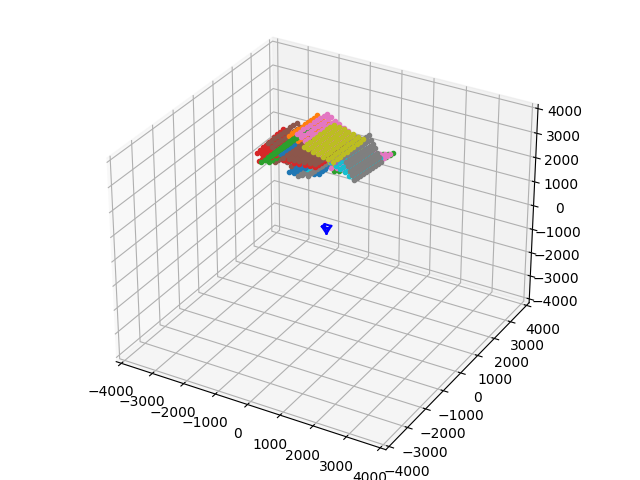

In [6]:
fig_in = plt.figure()
ax_in = Axes3D(fig_in, auto_add_to_figure=False)
fig_in.add_axes(ax_in)

ax_in.set_xlim(-plot_range, plot_range)
ax_in.set_ylim(-plot_range, plot_range)
ax_in.set_zlim(-plot_range, plot_range)

if plot_mode == 0: # fixed camera = plot in CCS
    
    plotCamera(ax_in, np.eye(3), np.zeros((1,3)), color="b", scale=camera_size) # camera is at (0,0,0)
    
    for i_ex in range(len(rvec)):
        X_C = np.zeros((X_W.shape))
        for i_x in range(X_W.shape[0]):
            R_w2c = cv2.Rodrigues(rvec[i_ex])[0] # convert to the rotation matrix
            t_w2c = tvec[i_ex].reshape(3)
            X_C[i_x,:] = R_w2c.dot(X_W[i_x,:]) + t_w2c # Transform chess corners in WCS to CCS
                
        ax_in.plot(X_C[:,0], X_C[:,1], X_C[:,2], ".") # plot chess corners in CCS
        
elif plot_mode == 1: # fixed chessboard = plot in WCS
    
    for i_ex in range(len(rvec)):
        R_c2w = np.linalg.inv(cv2.Rodrigues(rvec[i_ex])[0]) #　世界座標系におけるカメラの向き
        t_c2w = -R_c2w.dot(tvec[i_ex]).reshape((1,3)) # 世界座標系におけるカメラの位置
        
        plotCamera(ax_in, R_c2w, t_c2w, color="b", scale=camera_size)
        
    ax_in.plot(X_W[:,0], X_W[:,1], X_W[:,2], ".")



## Exercises

1. Draw the detected chess corners over the original images using `cv2.drawChessboardCorners()` for visualization.
2. Check the difference with / without the `cv2.CALIB_FIX_ASPECT_RATIO` flag.
3. Try with your own camera.
4. Try **ChArUco** patterns instead of chessboards.
   * [Detection of ChArUco Corners](https://docs.opencv.org/master/df/d4a/tutorial_charuco_detection.html)
